In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Bering = pd.read_excel(filepath, sheet_name='Bering-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Bering)
fp.date_time(Bering)

,Extent,Date
0,320266.650,1979-01-01
1,541778.338,1979-02-01
2,638262.988,1979-03-01
3,423025.159,1979-04-01
4,215587.216,1979-05-01
...,...,...
488,317377.493,2023-05-01
489,39601.476,2023-06-01
490,16935.702,2023-07-01
491,1305.744,2023-09-01


In [5]:
scaler = MinMaxScaler()
Bering['Extent'] = scaler.fit_transform(Bering['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 8
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Bering['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((474, 12, 1), (474,))

In [8]:
X_train, y_train = X[:384], y[:384]
X_val, y_val = X[384:432], y[384:432]
X_test, y_test = X[432:], y[432:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Bering_model_LT8/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
48/48 [==============================] - 19s 236ms/step - loss: 0.1633 - root_mean_squared_error: 0.4041 - val_loss: 0.0464 - val_root_mean_squared_error: 0.2154
Epoch 2/50
48/48 [==============================] - 7s 158ms/step - loss: 0.1205 - root_mean_squared_error: 0.3471 - val_loss: 0.0422 - val_root_mean_squared_error: 0.2054
Epoch 3/50
48/48 [==============================] - 1s 17ms/step - loss: 0.0953 - root_mean_squared_error: 0.3087 - val_loss: 0.0437 - val_root_mean_squared_error: 0.2089
Epoch 4/50
48/48 [==============================] - 1s 16ms/step - loss: 0.0859 - root_mean_squared_error: 0.2931 - val_loss: 0.0446 - val_root_mean_squared_error: 0.2111
Epoch 5/50
48/48 [==============================] - 1s 13ms/step - loss: 0.0711 - root_mean_squared_error: 0.2667 - val_loss: 0.0770 - val_root_mean_squared_error: 0.2775
Epoch 6/50
48/48 [==============================] - 1s 16ms/step - loss: 0.0488 - root_mean_squared_error: 0.2209 - val_loss: 0.1441 - val_roo

Epoch 47/50
48/48 [==============================] - 1s 17ms/step - loss: 0.0112 - root_mean_squared_error: 0.1060 - val_loss: 0.0883 - val_root_mean_squared_error: 0.2972
Epoch 48/50
48/48 [==============================] - 1s 15ms/step - loss: 0.0108 - root_mean_squared_error: 0.1037 - val_loss: 0.1011 - val_root_mean_squared_error: 0.3180
Epoch 49/50
48/48 [==============================] - 1s 14ms/step - loss: 0.0113 - root_mean_squared_error: 0.1064 - val_loss: 0.1002 - val_root_mean_squared_error: 0.3166
Epoch 50/50
48/48 [==============================] - 1s 15ms/step - loss: 0.0102 - root_mean_squared_error: 0.1012 - val_loss: 0.0898 - val_root_mean_squared_error: 0.2997


In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

1.111563511689504 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

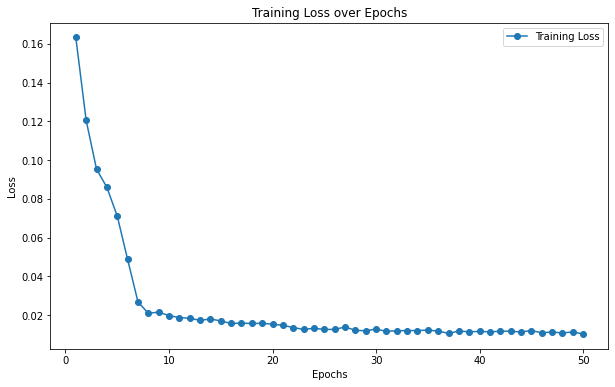

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

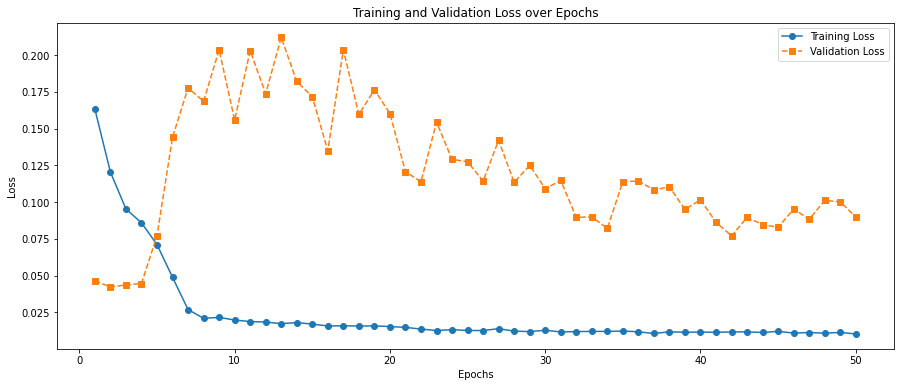

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Bering_model_LT8/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 17ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.2682589299164171
MAE : 0.24043067511932317


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,203164.906250,466524.938
1,205497.828125,708542.184
2,209829.828125,652598.000
3,214067.015625,414216.785
4,218265.031250,236263.303
5,222218.515625,43422.368
6,225753.609375,2161.744
7,229351.578125,944.181
8,228304.640625,13977.643
9,216328.140625,24795.001


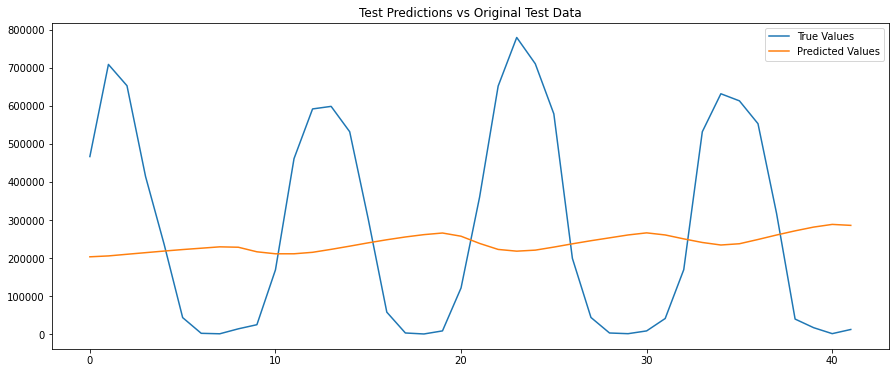

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

15/15 [==============================] - 0s 10ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

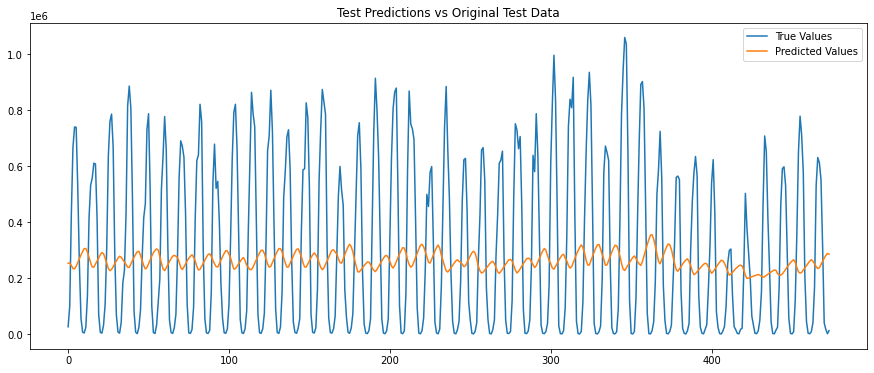

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()